In [2]:
import sys
sys.path.append("..")
import numpy as np
import keras.backend as K
import nea.asap_reader as dataset
import nea.utils as U

In [3]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.visible_device_list = "1"
set_session(tf.Session(config=config))

In [4]:
train_path = '../../data/fold_0/train.tsv'
dev_path = '../../data/fold_0/dev.tsv'
test_path = '../../data/fold_0/test.tsv'
prompt_id = int(1)
vocab_size = 4000
maxlen = 0
vocab_path = None
out_dir = 'output'
emb_dim = 50

In [5]:
from keras.preprocessing import sequence
# data_x is a list of lists
(train_x, train_y, train_pmt), (dev_x, dev_y, dev_pmt), (test_x, test_y, test_pmt), vocab, vocab_size, overal_maxlen, num_outputs = dataset.get_data(
(train_path, dev_path, test_path), prompt_id, vocab_size, maxlen, tokenize_text=True, to_lower=True, sort_by_len=False, vocab_path=vocab_path)

In [6]:
from keras.preprocessing import sequence
train_x = sequence.pad_sequences(train_x, maxlen=overal_maxlen)
dev_x = sequence.pad_sequences(dev_x, maxlen=overal_maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=overal_maxlen)

In [7]:
train_y = np.array(train_y, dtype=K.floatx())
dev_y = np.array(dev_y, dtype=K.floatx())
test_y = np.array(test_y, dtype=K.floatx())

In [8]:
train_pmt = np.array(train_pmt, dtype='int32')
dev_pmt = np.array(dev_pmt, dtype='int32')
test_pmt = np.array(test_pmt, dtype='int32')

In [9]:
train_mean = train_y.mean(axis=0)
train_std = train_y.std(axis=0)
dev_mean = dev_y.mean(axis=0)
dev_std = dev_y.std(axis=0)
test_mean = test_y.mean(axis=0)
test_std = test_y.std(axis=0)

In [10]:
bincounts, mfs_list = U.bincounts(train_y)
with open(out_dir+'/bincounts.txt', 'w+') as output_file:
    for bincount in bincounts:
        output_file.write(str(bincount) + '\n')

In [11]:
print('Statistics:')
print('  train_x shape: ' + str(np.array(train_x).shape))
print('  dev_x shape:   ' + str(np.array(dev_x).shape))
print('  test_x shape:  ' + str(np.array(test_x).shape))
print('  train_y shape: ' + str(train_y.shape))
print('  dev_y shape:   ' + str(dev_y.shape))
print('  test_y shape:  ' + str(test_y.shape))
print('  train_y mean: %s, stdev: %s, MFC: %s' % (str(train_mean), str(train_std), str(mfs_list)))

Statistics:
  train_x shape: (1070, 939)
  dev_x shape:   (356, 939)
  test_x shape:  (357, 939)
  train_y shape: (1070,)
  dev_y shape:   (356,)
  test_y shape:  (357,)
  train_y mean: 8.553271, stdev: 1.5372216, MFC: [8.0]


In [12]:
initial_mean_value = train_y.mean(axis=0)
if initial_mean_value.ndim == 0:
    initial_mean_value = np.expand_dims(initial_mean_value, axis=1)
num_outputs = len(initial_mean_value)
num_outputs

/home/nlplab/ting/anaconda3/envs/elmobilstm/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


1

In [13]:
# We need the dev and test sets in the original scale for evaluation
dev_y_org = dev_y.astype(dataset.get_ref_dtype())
test_y_org = test_y.astype(dataset.get_ref_dtype())
# Convert scores to boundary of [0 1] for training and evaluation (loss calculation)
train_y = dataset.get_model_friendly_scores(train_y, train_pmt)
dev_y = dataset.get_model_friendly_scores(dev_y, dev_pmt)
test_y = dataset.get_model_friendly_scores(test_y, test_pmt)

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Activation
from keras.layers import Dropout, GlobalAveragePooling1D
from keras.layers import LSTM , Bidirectional
from nea.optimizers import get_optimizer

In [28]:
loss = 'mean_squared_error'
metric = 'mean_absolute_error'
opt = get_optimizer('rmsprop')

In [29]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=overal_maxlen))
model.add(LSTM(256 , return_sequences=True))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling1D())
model.add(Dense(num_outputs, activation='sigmoid'))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 939, 50)           200000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 939, 256)          314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 939, 256)          0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 514,625
Trainable params: 514,625
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss=loss,
              optimizer=opt,
              metrics=[metric])

In [32]:
from nea.evalute import Evaluator
evl = Evaluator(dataset, prompt_id, out_dir, dev_x, test_x, dev_y, test_y, dev_y_org, test_y_org)
evl.evaluate(model, -1, print_info=True)

[Dev]   loss: 0.0465, metric: 0.1771, mean: 6.995 (8.508), stdev: 0.003 (1.539)
[Test]  loss: 0.0455, metric: 0.1802, mean: 6.994 (8.473), stdev: 0.003 (1.538)
[DEV]   QWK:  0.000, LWK: 0.000, PRS: 0.803, SPR: 0.798, Tau: 0.660 (Best @ -1: {{0.000}}, 0.000, 0.803, 0.798, 0.660)
[TEST]  QWK:  0.000, LWK: 0.000, PRS: 0.781, SPR: 0.778, Tau: 0.638 (Best @ -1: {{0.000}}, 0.000, 0.781, 0.778, 0.638)
--------------------------------------------------------------------------------------------------------------------------


In [33]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
history = model.fit(
    train_x , train_y , batch_size=32 , epochs=20 , validation_data=(dev_x , dev_y) , callbacks=callbacks , verbose=1)

Train on 1070 samples, validate on 356 samples
Epoch 1/20
1070/1070 [==============================] - 38s 35ms/step - loss: 0.0281 - mean_absolute_error: 0.1264 - val_loss: 0.0263 - val_mean_absolute_error: 0.1218
Epoch 2/20
1070/1070 [==============================] - 37s 35ms/step - loss: 0.0172 - mean_absolute_error: 0.0997 - val_loss: 0.0126 - val_mean_absolute_error: 0.0817
Epoch 3/20
1070/1070 [==============================] - 37s 35ms/step - loss: 0.0095 - mean_absolute_error: 0.0755 - val_loss: 0.0074 - val_mean_absolute_error: 0.0676
Epoch 4/20
1070/1070 [==============================] - 37s 35ms/step - loss: 0.0085 - mean_absolute_error: 0.0722 - val_loss: 0.0072 - val_mean_absolute_error: 0.0647
Epoch 5/20
1070/1070 [==============================] - 37s 35ms/step - loss: 0.0082 - mean_absolute_error: 0.0701 - val_loss: 0.0077 - val_mean_absolute_error: 0.0655
Epoch 6/20
1070/1070 [==============================] - 37s 35ms/step - loss: 0.0080 - mean_absolute_error: 0.069

In [23]:
import pandas as pd
hist = pd.DataFrame(history.history)

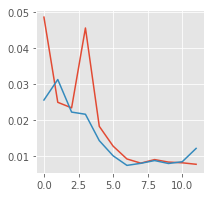

In [25]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(3,3))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [26]:
evl.evaluate(model,0)
evl.print_info()

[Dev]   loss: 0.0121, metric: 0.0891, mean: 7.805 (8.508), stdev: 1.300 (1.539)
[Test]  loss: 0.0124, metric: 0.0886, mean: 7.768 (8.473), stdev: 1.256 (1.538)
[DEV]   QWK:  0.733, LWK: 0.492, PRS: 0.835, SPR: 0.829, Tau: 0.693 (Best @ 0: {{0.733}}, 0.492, 0.835, 0.829, 0.693)
[TEST]  QWK:  0.709, LWK: 0.470, PRS: 0.829, SPR: 0.819, Tau: 0.682 (Best @ 0: {{0.709}}, 0.470, 0.829, 0.819, 0.682)
--------------------------------------------------------------------------------------------------------------------------
